In [1]:
library(ggplot2)
library(viridis)
library(dplyr)

plotfactors = function(location,exposures){
        exp1 = exposures/rowSums(exposures)
        exp1 = t(t(exp1)/colSums(exp1)) 
        plotdat = data.frame(x = location[,1], y = location[,2], all = exp1)

        datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1,2)], direction = 'long', v.names = "prob")
        datalong$weight = datalong$prob
        qmax = quantile(datalong$weight, 0.95)
        datalong$weight[datalong$prob > qmax] = qmax


        g1 = ggplot(datalong, aes(x = x, y = y, col = weight))+
        geom_point(cex = 0.2)+ 
        facet_wrap(~time, ncol = 5)+ 
        theme(axis.text = element_blank(),
        axis.ticks=element_blank(), 
        axis.title = element_blank(), legend.position = "none")+
        scale_color_viridis()
        
        return(g1)

}

Loading required package: viridisLite

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Spatial NMF

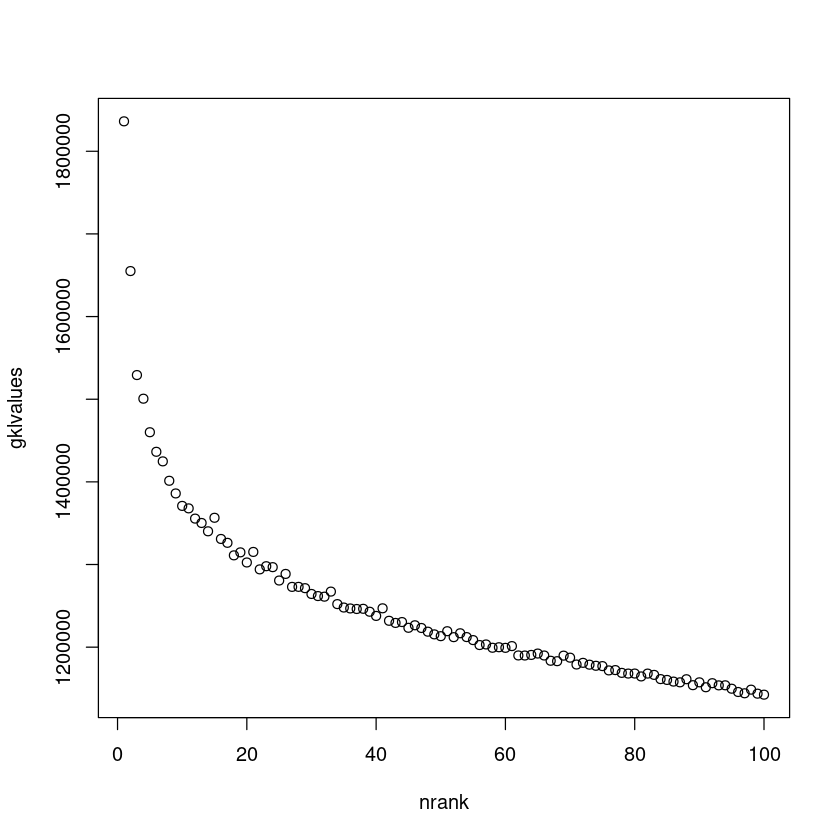

In [2]:

# get the gkl values
gklvalues = c()
i = 1
nrank = c(1:100)
for( x in nrank){
    load(paste0("modelssaved/LH5K_f",x,"_l001.RData"))
    gklvalues[i] = out$gkl
    i = i+1
}

plot(nrank,gklvalues)

In [83]:


location = read.csv('data/LH_location.csv')
location = location[,-1]
location = as.matrix(location)



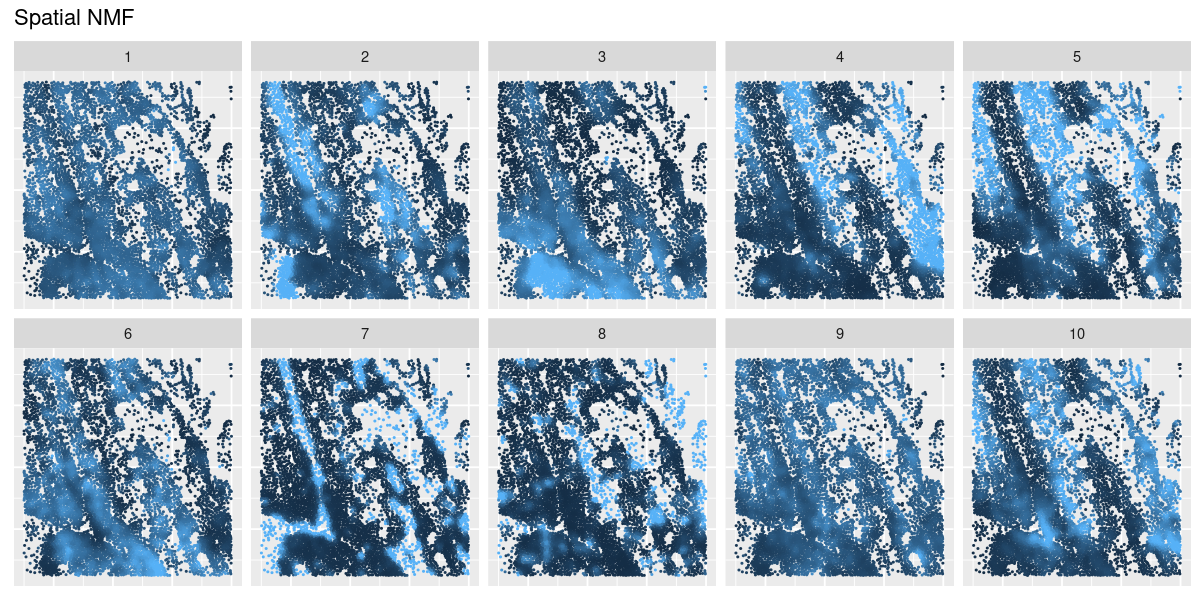

In [93]:


load("modelssaved/LH5K_f10_l0005.RData")
options(repr.plot.width=10, repr.plot.height=5)
plotfactors(location,out$exposures) + ggtitle("Spatial NMF")

# Batch NMF

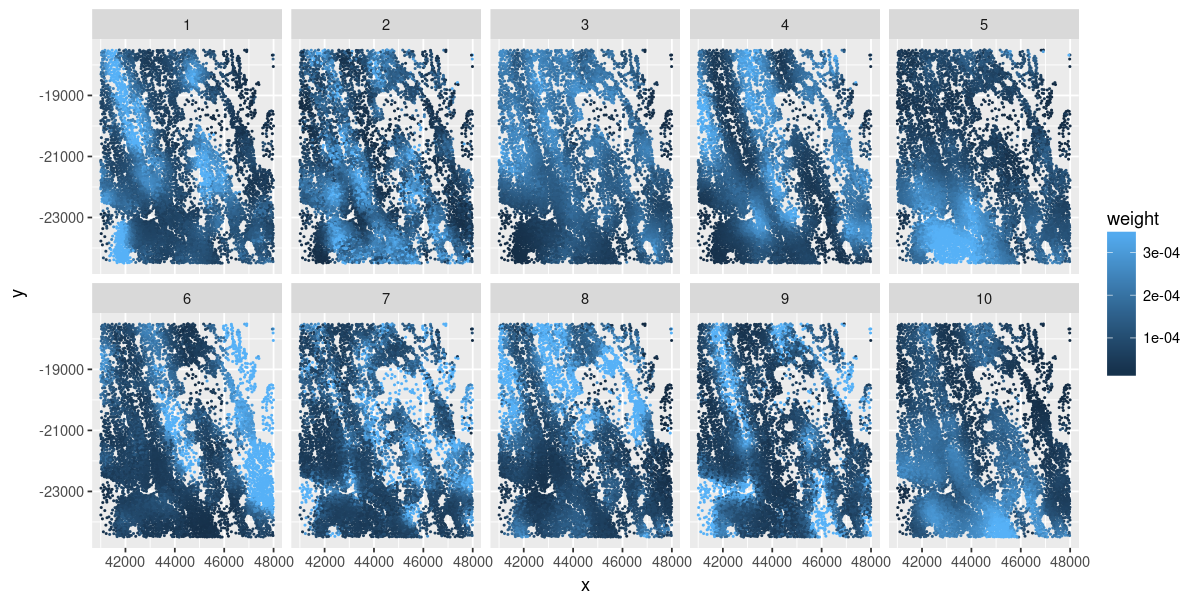

In [11]:
load("modelssaved/LH_f10_trybatch_500.RData")

plotfactors(location,out$exposures)

# Regular NMF

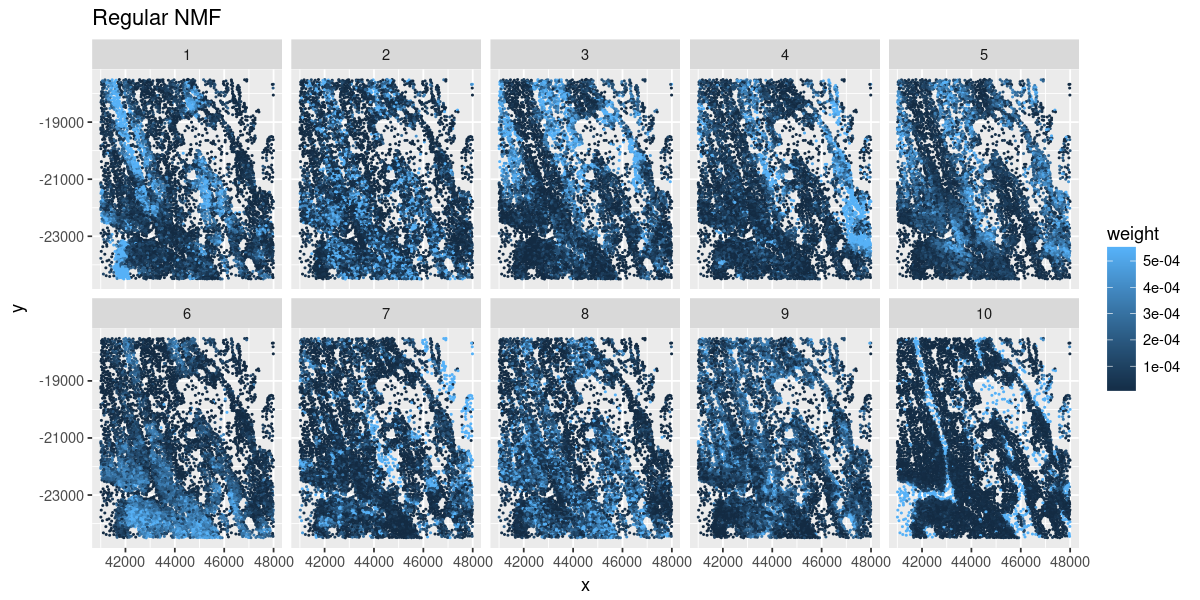

In [13]:
load("modelssaved/LH_f10_regnmf.RData")

plotfactors(location,out$exposures) + ggtitle("Regular NMF")

# Vizgen data

In [2]:
library(ggplot2)
library(dplyr)

In [16]:
load("modelssaved/cellpose_f20_b150_l100_1e10.RData")
#load("modelssaved/cellpose_f20_nmfgen.RData")

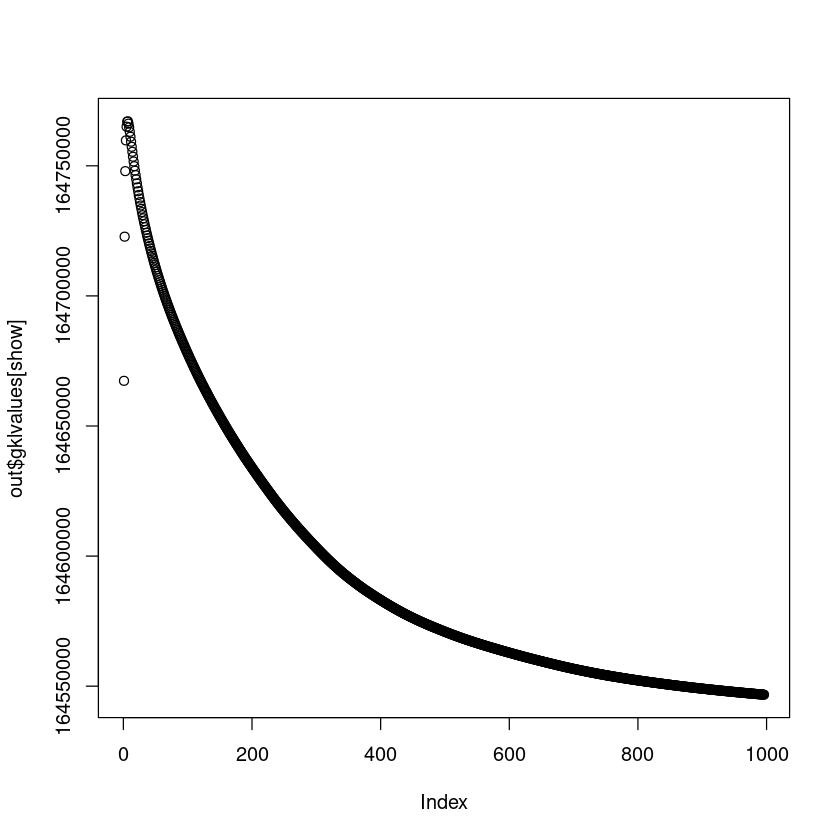

In [17]:
show = c(5:1000)
plot(out$gklvalues[show])

In [6]:
# no gene count 
no_count = read.csv('data/cell_no_gene_count.csv')[,2]

In [7]:
# load data for celltype plot
total = nrow(out$exposures) + length(no_count)
print(total)
celltype = rep("none",total)
cell_annotation = read.csv('data/midlevel_type.csv')

celltype[cell_annotation[,1] + 1] = as.character(cell_annotation[,2])

[1] 844468


In [8]:
celltype = celltype[-no_count]
length(celltype)

[1] 841070

In [9]:
path2 = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_metadata.csv'
metadata = read.csv(path2, row.names = 1)

location = metadata[,c('center_x','center_y')]
location = as.matrix(location)
print(nrow(location))
location = location[-no_count,]

[1] 844468


In [10]:
# get the genes
path1 = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_by_gene_goodgenes_noblanks.csv'
count = read.csv(path1, row.names = 1)
genes = colnames(count)


In [18]:
#subregion 3
#idx_sub = which( location[,1] > 41000 & location[,1] < 48000 &  location[,2] > 30000 & location[,2] < 37000)
# subregion1
#idx_sub = which( location[,1] > 41000 & location[,1] < 48000 &  location[,2] > 17500 & location[,2] < 24500)
idx_sub = sample(length(celltype),50000)


In [19]:
exp_sub = out$exposures[idx_sub,]
celltype_sub = celltype[idx_sub]

In [20]:
location_sub = location[idx_sub,]
location_sub[,2] = -location_sub[,2]

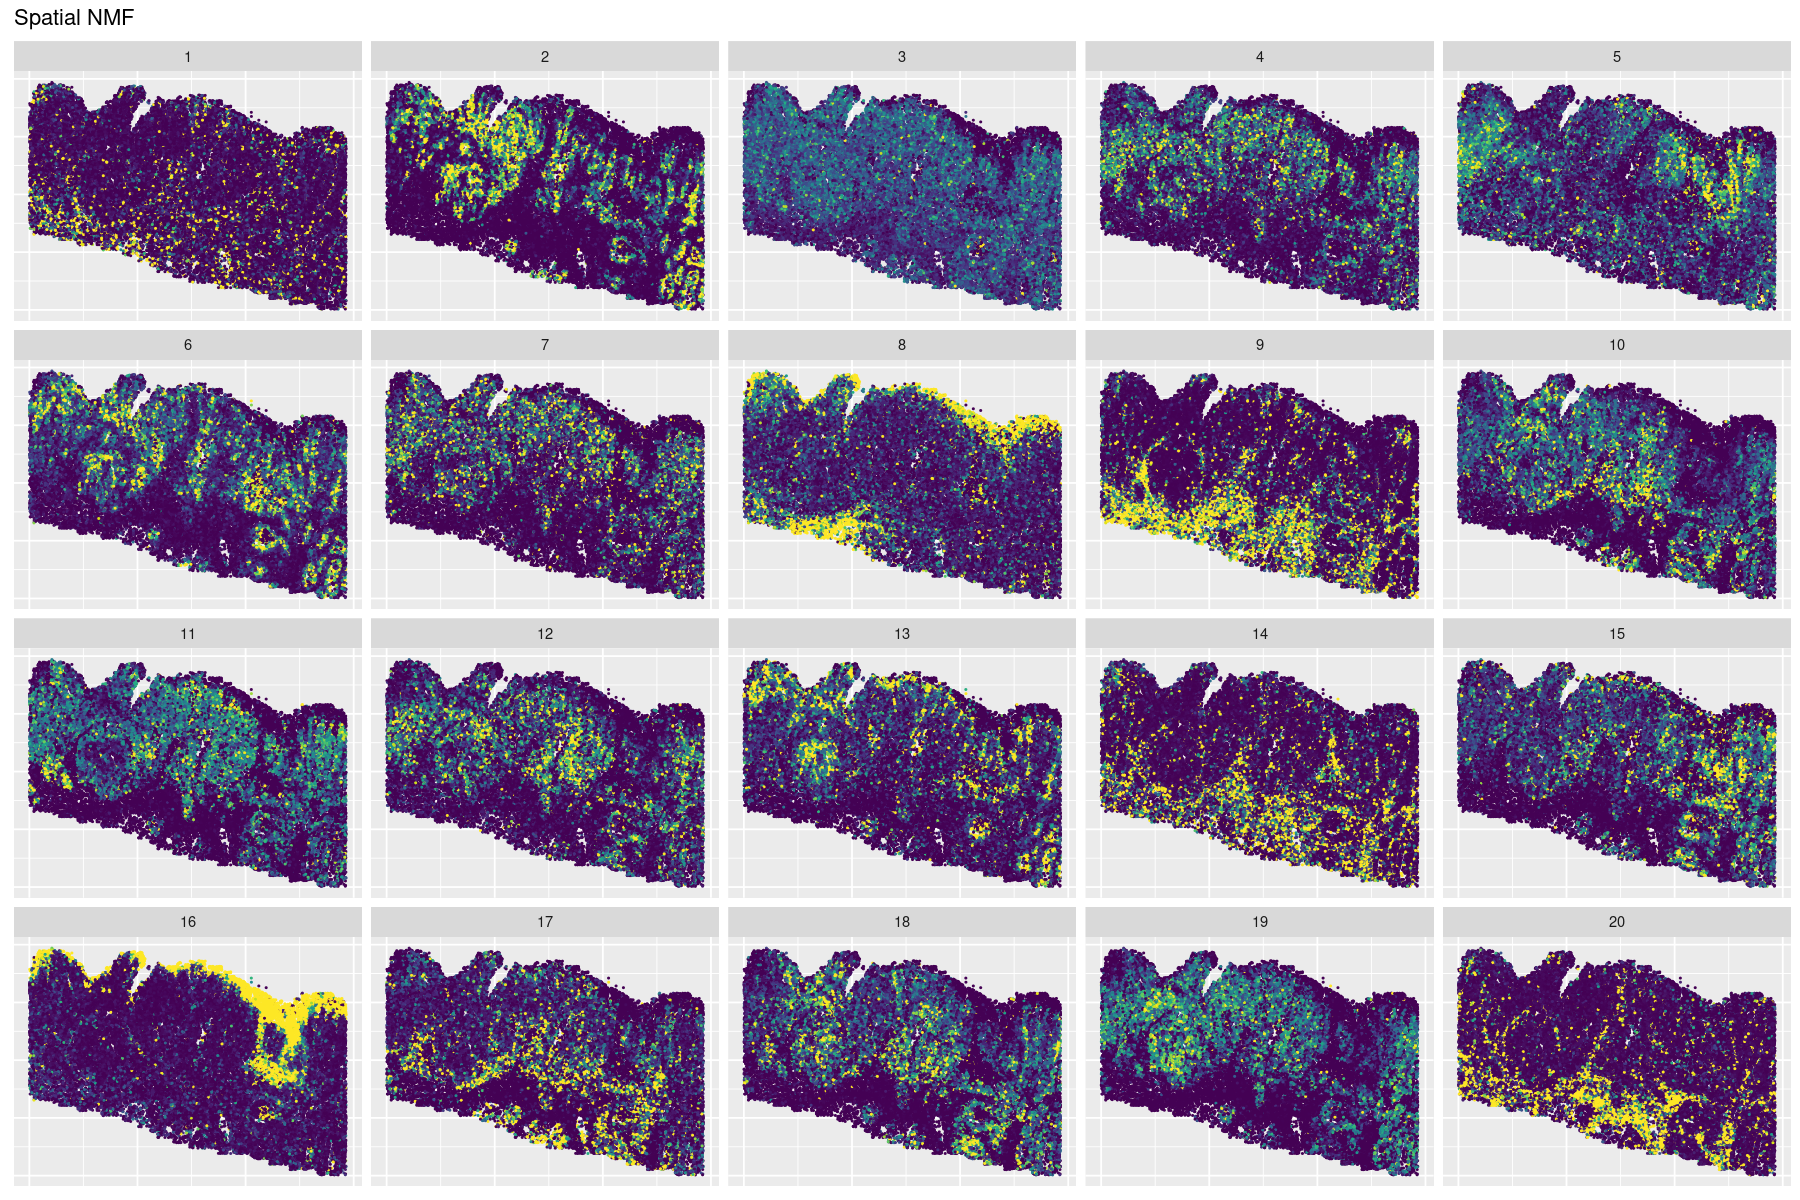

In [21]:
options(repr.plot.width=15, repr.plot.height=10)
plotfactors(location_sub,exp_sub) + ggtitle("Spatial NMF")

In [36]:
orderindex = celltype_sub
norm_exp = exp_sub/rowSums(exp_sub)
for( x in 1:ncol(exp_sub)){
    orderindex = paste0(orderindex,round(norm_exp[,x],2))
}
orderindex = paste0(orderindex, 1:length(orderindex))
plotdat = data.frame(index = orderindex,celltype = celltype_sub, all = norm_exp)

datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1:2)], direction = 'long', v.names = "prob")

datalong$topic = factor(datalong$time)

In [23]:
myCol = c("pink1", "mediumpurple1", "purple3",
          "turquoise2", "skyblue", "steelblue", "blue2", "navyblue",
          "orange", "tomato", "coral2", "palevioletred", "violetred", "red2",
          "springgreen2", "yellowgreen", "palegreen4", "tan3", "brown",
          "grey70")

length(myCol)

[1] 20

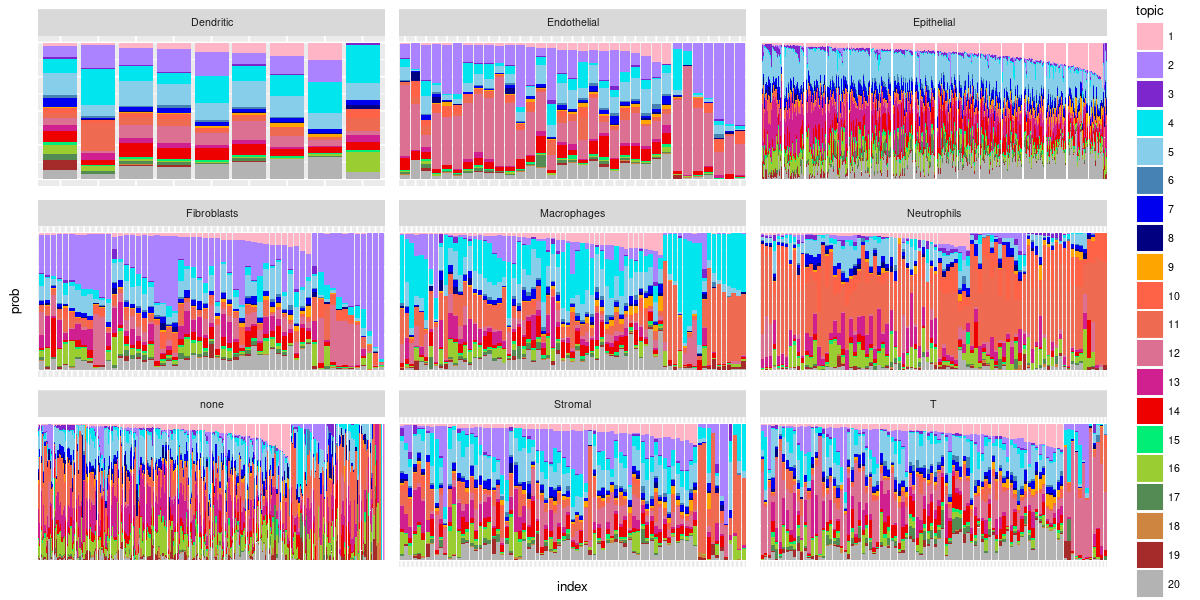

In [37]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(datalong, aes(x = index, y = prob, fill = topic))+
         geom_bar(position="stack", stat="identity")+
         theme(axis.text = element_blank(),
         axis.ticks=element_blank(), 
         text = element_text(size = 8))+
         facet_wrap(~celltype, scale = "free")+
         scale_fill_manual(values=myCol)


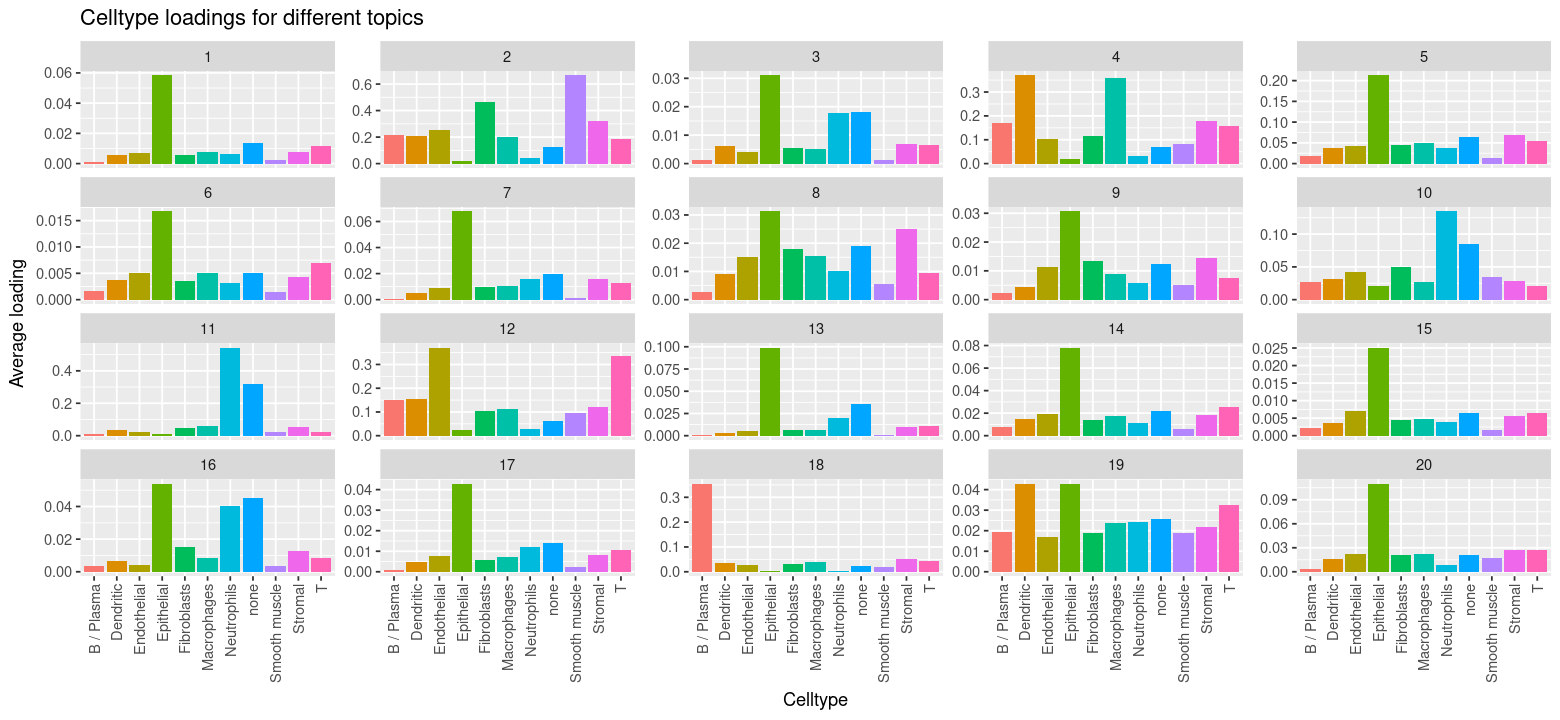

In [19]:
norm_exp = out$exposures/rowSums(out$exposures)

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), mean)

cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

In [ ]:

plotdat = data.frame(x = location[,1], y = location[,2], all = norm_exp[,topic])

In [15]:
# Weighting from paper
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr*log((rr+1e-10)/(mm+1e-10))
  dat_new=rbind(dat_new, ns)
}

weight_topgene = NULL
ng = 50
for(topic in 1:20){
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]

    weight_topgene = rbind(weight_topgene,c(topic,weighting))

}
write.csv(data.frame(weight_topgene), "resultplots/topgenes_cellpose_regnmf.csv", row.names=FALSE)
weight_topgene[,1:26]

[,1] [,2]     [,3]    [,4]    [,5]    [,6]   [,7]   [,8]   [,9]   
 [1,] 1    FOS      EGR1    JUNB    SOCS3   IL1B   PTGS2  CXCL8  ATF3   
 [2,] 2    MZB1     CD79A   XBP1    POU2AF1 FCRL5  IRF4   DERL3  CD27   
 [3,] 3    TGFBI    TGFBR2  IL12B   EGF     SOX2   CASP8  TBX10  DUSP6  
 [4,] 4    CXCL10   HLA.DRA IDO1    TAP2    TAP1   STAT1  HLA.B  CXCL11 
 [5,] 5    MKI67    PLK1    CCNB1   AURKA   BIRC5  FOXM1  AURKB  BUB1   
 [6,] 6    SERPINA1 MMP1    S100A9  CEACAM1 NOS2   MUC1   STAT3  CEACAM8
 [7,] 7    CDH1     EPCAM   ERBB3   SPRY2   TMEM37 SRPRB  SRC    ARAF   
 [8,] 8    PLVAP    VWF     COL4A1  ENG     CDH5   MMRN2  KDR    PGF    
 [9,] 9    EPHB3    PROX1   ASCL2   CTNNB1  CDKN1B NOTCH1 DNMT3A RGMB   
[10,] 10   COL1A1   FN1     ACTA2   COL5A1  PDGFRB SFRP2  DES    MMP11  
[11,] 11   VEGFA    DDIT3   TNFSF9  TCF7L2  CA7    ROS1   ICOSLG WNT3A  
[12,] 12   NDUFA4L2 CA9     SLC26A3 LRP1    LDHA   PKIB   CDKN1A IFNGR2 
[13,] 13   GNLY     GZMA    CD2     CD3E    TRAC   IL2RB  CCL5   CTSW   
[14,] 14   C1QC     LYZ     SPP1    FCGR3A  CSF1R  CYBB   CD14   MMP12  
[15,] 15   SOX9     YAP1    IGF1    IKZF4   PTGDR2 CCL1   VTN    TCL1A  
[16,] 16   MCM2     MCM6    PCNA    E2F1    MSH6   CDK2   MSH2   CDCA7  
[17,] 17   MYC      MUC2    EPHB4   IL12A   IFNGR1 IRS1   CD160  SHARPIN
[18,] 18   AXIN2    PRKCA   LGR6    LRP5    ERBB2  TBX3   IRF3   LEF1   
[19,] 19   LAMC2    LAMB3   EPHA2   BCL2L1  ITGB1  GPX3   AMOTL2 MET    
[20,] 20   PKM      HDAC1   IDH1    NRAS    DIABLO RELA   LMNA   SMAD2  
      [,10]     [,11] [,12]   [,13]   [,14]     [,15]  [,16]    [,17]   
 [1,] JUN       ⋯     CCL3    CXCL5   PROK2     IL6    CXCR1    IL1R2   
 [2,] TNFRSF13C ⋯     BLK     BMI1    MS4A1     HLA.C  STAP1    PIK3CG  
 [3,] CCL1      ⋯     CD68    TCL1A   CCL28     IL22   CCL26    PPARGC1A
 [4,] CIITA     ⋯     TNFSF10 LAMP3   BST2      CCL22  CXCL9    CD274   
 [5,] CHEK2     ⋯     TMEM59  LGR5    IRF5      CXCL2  IL6      LEF1    
 [6,] PRTN3     ⋯     IL4     IDO2    ARG1      IL5RA  PAX5     CLCA1   
 [7,] TBK1      ⋯     TP63    CD1B    FGFBP2    PAX5   PDGFC    CR2     
 [8,] PECAM1    ⋯     ANGPT2  FLT1    ITGA5     THBD   PREX2    IL3RA   
 [9,] LGR5      ⋯     CCL1    VTN     KLRF1     CCL26  PPARGC1A TP63    
[10,] COL11A1   ⋯     FGFR1   TNC     COL6A3    FAP    LOX      SNAI2   
[11,] FABP2     ⋯     CXCR1   STAP1   CTSG      MARCO  SIGLEC1  TNF     
[12,] PLOD2     ⋯     ELANE   CD160   IDO2      IL5RA  CD1B     FGFBP2  
[13,] ZAP70     ⋯     ITK     CD5     STAT4     CCR4   PTPRC    TNFRSF18
[14,] MRC1      ⋯     CD163   ITGAM   TLR2      MAFB   MSR1     CSF2RA  
[15,] CCL28     ⋯     CD1B    RET     TNFRSF13B CD207  MMP2     XCR1    
[16,] MYBL2     ⋯     DNMT1   MLH1    EZH2      NFE2L2 MAP2K1   TEAD4   
[17,] BAK1      ⋯     IDO2    FABP2   PAX5      TBX10  FCER1A   TMEM59  
[18,] STAT6     ⋯     KLRC1   TGFBR3  LRP6      MSH3   IKBKB    CCL11   
[19,] ZBED2     ⋯     TEAD1   DKK1    RET       CD276  IL17A    FOSL1   
[20,] BAX       ⋯     PTGDR2  PGLYRP1 IL13      CD68   TCL1A    XCL1    
      [,18]   [,19]  [,20]  [,21] 
 [1,] CXCR2   CD83   ELANE  CXCL2 
 [2,] IL6R    TMEM59 PAX5   ATM   
 [3,] FLI1    ELANE  CD160  IL4   
 [4,] CSF3    NFKB2  NLRC5  BTLA  
 [5,] RORC    MMP7   CXCL1  TGFBR3
 [6,] CXCR2   ROR1   CCR10  XCR1  
 [7,] CCR3    CXCR2  CD207  FGFR2 
 [8,] KLF2    SNAI1  CAV1   VEGFC 
 [9,] FABP2   IFNB1  CD1B   CCR3  
[10,] ELN     SMO    ITGA1  MFAP5 
[11,] CD22    EPHA4  CXCL5  TGFB2 
[12,] PAX5    RET    PRTN3  CR2   
[13,] GATA3   KLRK1  CD28   IKZF2 
[14,] CD86    ITGB2  CMKLR1 CD209 
[15,] CSF2    ANGPT1 FGF1   HGF   
[16,] WNT3    CD207  HRAS   CR2   
[17,] SELL    ESCO2  FCER2  DKK1  
[18,] SLC13A3 TP63   PIK3CA PMS2  
[19,] KLRF1   TBX10  XCR1   CCL11 
[20,] CCL28   IL22   ELANE  IL10

In [14]:
# More distinct genes
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr/mm
  dat_new=rbind(dat_new, ns)
}

weight_topgene = NULL
ng = 10
for(topic in 1:20){
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]

    weight_topgene = rbind(weight_topgene,c(topic,weighting))

}

weight_topgene

write.csv(data.frame(weight_topgene), "resultplots/topgenes_cellpose_regnmf_distinct.csv", row.names=FALSE)


[,1] [,2]     [,3]     [,4]   [,5]    [,6]    [,7]   [,8]   [,9]   
 [1,] 1    FOS      EGR1     PTGS2  CXCL8   FFAR2   ATF3   CXCL5  IL1B   
 [2,] 2    MZB1     CD79A    FCRL5  POU2AF1 XBP1    IRF4   DERL3  CD19   
 [3,] 3    TGFBI    IL12B    EGF    SOX2    TGFBR2  CASP8  TBX10  DUSP6  
 [4,] 4    CXCL10   IDO1     CXCL11 CX3CL1  STAT1   CCL22  TAP1   CD274  
 [5,] 5    PLK1     CCNB1    MKI67  AURKA   AURKB   BUB1   BIRC5  FOXM1  
 [6,] 6    MMP1     SERPINA1 S100A9 CEACAM1 CEACAM8 PRTN3  NOS2   STAT3  
 [7,] 7    SPRY2    CDH1     ARAF   ERBB3   IFNB1   SRC    SRPRB  TMEM37 
 [8,] 8    PLVAP    VWF      CLDN5  CDH5    KDR     PGF    MMRN2  CLEC14A
 [9,] 9    EPHB3    PROX1    ASCL2  LGR5    FGFR2   CDKN1B DNMT3A RGMB   
[10,] 10   COL1A1   DES      COL5A1 COL11A1 ACTA2   PDGFRB FN1    PDGFRA 
[11,] 11   VEGFA    TNFSF9   DDIT3  CA7     ROS1    TCF7L2 ICOSLG WNT3A  
[12,] 12   NDUFA4L2 SLC26A3  PKIB   CA9     LRP1    NEDD4  LDHA   IFNGR2 
[13,] 13   GNLY     GZMA     CD2    CD3E    TRAC    IL2RB  TIGIT  CCL5   
[14,] 14   CSF1R    LYZ      C1QC   MRC1    SPP1    FCGR3A MMP12  CD163  
[15,] 15   SOX9     IGF1     YAP1   IKZF4   BRD4    CR2    CXCL12 CREBBP 
[16,] 16   MCM6     E2F1     MCM2   MSH6    CCNE1   PCNA   MSH2   CDK2   
[17,] 17   MUC2     MYC      IL12A  CD160   EPHB4   ARG1   IFNGR1 IRS1   
[18,] 18   AXIN2    CCR6     PRKCA  LEF1    TP63    KLRC1  FGFR3  CCL11  
[19,] 19   LAMC2    LAMB3    MMP7   FGF2    BCL2L1  EPHA2  GPX3   AMOTL2 
[20,] 20   PKM      NRAS     DIABLO IDH1    HDAC1   RELA   HDAC3  SMAD2  
      [,10]     [,11] [,12] [,13]   [,14]  [,15]  [,16]  [,17]    [,18]   
 [1,] SOCS3     ⋯     SOD2  CR2     FABP2  IL22   VTN    IGF1     CD68    
 [2,] TNFRSF13C ⋯     HIF1A BRAF    MTOR   MMP2   PECAM1 CTSG     MFAP5   
 [3,] KIR2DL4   ⋯     SRPRB TSC2    IKZF4  CCR3   TGM2   BAX      IGF1R   
 [4,] TAP2      ⋯     IL21  CXCL1   NFKB1  HLA.C  TGFB2  HLA.DPA1 STAT5A  
 [5,] XCL1      ⋯     HDAC3 MLH1    LMNA   ATR    BAX    CCL7     TSC2    
 [6,] MUC1      ⋯     CEBPB ELANE   IFITM1 TMEM37 MPO    IFNAR1   LRP1    
 [7,] EPCAM     ⋯     MTOR  LGALS9  HLA.B  TCL1A  TGFBR1 BRAF     TAPBP   
 [8,] FLT1      ⋯     CD276 IL4     ETS1   STING1 EPHA4  VCAM1    IL17A   
 [9,] NOTCH1    ⋯     LRP5  JUN     SPRY2  CSF2   BRD4   TCL1A    CCL11   
[10,] SMO       ⋯     PDGFC TGFBR1  AKT3   CCL2   CXCL12 CD276    TGFB1   
[11,] WNT3      ⋯     BAK1  PDGFA   BRAF   PIK3CA IGF1R  FGFR3    CD70    
[12,] PLOD2     ⋯     FCER2 CCR3    FLI1   SPRY2  TAPBP  CXCL16   PKM     
[13,] CTSW      ⋯     BCL2  IL12RB2 KLRG1  CCR7   CCL4   PTPRC    PRF1    
[14,] TREM2     ⋯     CD4   IL13    PDK4   IDO2   CCL2   CD80     HLA.DPA1
[15,] JUN       ⋯     MPO   PROK2   HRAS   VEGFB  HDAC1  ERBB2    LGALS9  
[16,] DNMT1     ⋯     CD83  HDAC1   MSH3   EPHB4  IGF1R  VEGFB    CCL1    
[17,] CCL1      ⋯     CASP8 HDAC3   CCL7   DUSP6  IRF3   TGFB2    ELANE   
[18,] TBX3      ⋯     NEDD4 SRC     MPO    TSC2   SMAD2  NOTCH1   YAP1    
[19,] PDGFA     ⋯     BRD4  IRF3    CREBBP TGFBR1 CSF2   PIK3CA   TBK1    
[20,] BAX       ⋯     PTEN  SELP    CXCL12 KLRC1  CD244  MUC4     CXCL16  
      [,19]   [,20]    [,21]  
 [1,] TCL1A   ITGAX    TNF    
 [2,] SIGLEC1 IL21     IRF3   
 [3,] MAP2K1  STAT1    YAP1   
 [4,] CD83    CCR10    CXCL2  
 [5,] AKT1    ROR1     CD68   
 [6,] HLA.B   NFKB1    TGFB2  
 [7,] IFNGR1  IDH1     CASP8  
 [8,] PDK4    TGFB1    TNFRSF4
 [9,] BMI1    STAT3    EPHB4  
[10,] PTEN    VEGFB    WNT3A  
[11,] IKZF4   FGFR2    SMAD2  
[12,] MAP2K1  SIGLEC1  SELP   
[13,] KIT     GZMB     CXCR4  
[14,] TGFBR1  PTGDR2   PDGFC  
[15,] CD160   KIR2DL4  TEAD4  
[16,] EGFR    TGFBR1   RGMB   
[17,] NOS3    AKT1     NLRC5  
[18,] IFITM1  ATR      CSF2   
[19,] SHARPIN STAT6    ARAF   
[20,] SOD2    PPARGC1A IL17A

In [53]:
library(pals)

ERROR: Error in library(pals): there is no package called ‘pals’


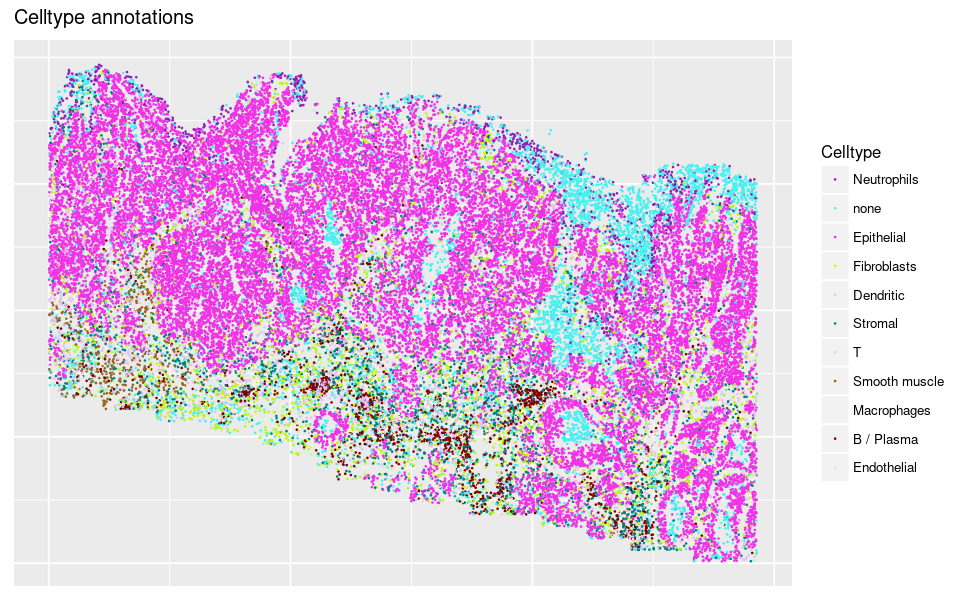

In [17]:
myCol = c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000')

options(repr.plot.width=8, repr.plot.height=5)
dat1 = data.frame(x = location_sub[,1], y = location_sub[,2], Celltype = celltype_sub)
dat1$Celltype = factor(dat1$Celltype, levels = unique(dat1$Celltype))
ggplot(dat1, aes(x = x, y = y, color = Celltype))+
        geom_point(cex = 0.1, alpha = 1)+
        #facet_wrap(~type)+
        theme(text = element_text(size = 10), 
        axis.text = element_blank(),
        axis.ticks=element_blank(), 
        axis.title = element_blank()
        )+
        ggtitle("Celltype annotations")+
        scale_color_manual(values=myCol[6:16])
        

In [55]:
sum(celltype == 'Epithelial cells')

[1] 516739